# DeepWalk in python

## Imports

In [ ]:
import random
import networkx as nx 
from gensim.models import Word2Vec

import numpy as np
from abc import ABC
import pandas as pd

## Deepwalk

In [ ]:
class DeepWalk:
  """
  Implement DeepWalk algorithm.
  reference paper : DeepWalk: Online Learning of Social Representations
  link : https://arxiv.org/abs/1403.6652
  Using the algorithm can get graph embedding model with your network data.
  """
  def __init__(self, G=None, adjlist_path=None, edgelist_path=None):
    """
    Parameters
    G : networkx : networkx graph.
    
    adjlist_path : network file path. 
    """
    if G == adjlist_path == edgelist_path == None:
      raise ValueError('all parameter is None, please check your input.')
      
    try:
      
      if G != None:
        self.G = G
      elif adjlist_path != None:
        self.G = nx.read_adjlist(adjlist_path)
      elif edgelist_path != None:
        self.G = nx.read_edgelist(edgelist_path)

    except Exception as e:
      print(e)


  def random_walk(self, iterations, start_node=None, random_walk_times=5):
    """
    : Implement of random walk algorithm :
    Parameters
    ----------------------------------------
    iterations : int : random walk number of iteration 
    start_node : str : choose start node (random choose a node, if start_node is None)
    random_walk_times : int : random walk times.
    ----------------------------------------
    Returns
    walk_records : list of walks record
    """
    walk_records = []

    for i in range(iterations):
      
      if start_node is None:
        s_node = random.choice(list(self.G.nodes()))
        walk_path = [s_node]
      else:
        walk_path = [start_node]
        
      current_node = s_node
      while(len(walk_path) < random_walk_times):
        neighbors = list(self.G.neighbors(current_node))
        
        
        current_node = random.choice(neighbors)
        walk_path.append(current_node)
          
      walk_records.append(walk_path)
    
    return walk_records

  def buildWord2Vec(self, **kwargs):
    """
    
    Using gensim to build word2vec model
    Parameters
    ----------------------------------------
    **kwargs
    
    walk_path : list : random walk results
    size : int : specific embedding dimension, default : 100 dim
    window : int : specific learn context window size, default : 5
    workers : int : specific workers. default : 2
    ----------------------------------------
    Returns
    walk_records : list of walks record
    """
    
    walk_path = kwargs.get('walk_path', None)
    if walk_path is None:
      return 
    
    size = kwargs.get('size', 100)
    window = kwargs.get('window', 5)
    workers = kwargs.get('workers', 2)

    embedding_model = Word2Vec(walk_path, size=size, window=window, min_count=0, workers=workers, sg=1, hs=1)

    return embedding_model

## Hierarchical Softmax
First, we'll build the components required to use hierarchical softmax. From the paper:

Computing the partition function (normalization factor) is expensive. If we assign the vertices to the leaves of a binary tree, the prediction problem turns into maximizing the probability of a specific path in the tree

Thus, instead of having a classifier that predicts probabilities for each word from our vocabulary (besides the one we're currently iterating on), we can structure the loss function as a binary tree where every internal node contains its own binary classifier. Computing the loss (and gradient) can therefore be done in $O(logv)$ predictions rather than $O(v)$ (as is the case with $v$ labels), where $v$ is the number of vertices in our graph.

In [ ]:
class Tree(ABC): 
    @staticmethod
    def merge(dims, lr, batch_size, left=None, right=None):
        if left is not None: left.set_left()
        if right is not None: right.set_right()
        return InternalNode(dims, lr, batch_size, left, right)
    
    @staticmethod
    def build_tree(nodes, dims, lr, batch_size):
        if len(nodes) % 2 != 0: nodes.append(None)
        while len(nodes) > 1:
            nodes = [Tree.merge(dims, lr, batch_size, nodes[i], nodes[i+1]) for i in range(0, len(nodes) - 1, 2)]
        return nodes[0]
        
    def set_parent(self, t):
        self.parent = t
        
    def set_left(self): self.is_right = False
        
    def set_right(self): self.is_right = True

In [ ]:
class InternalNode(Tree):
    def __init__(self, dims, lr, batch_size, left=None, right=None, parent=None, is_right=None):
        self.dims = dims
        self.set_left_child(left)
        self.set_right_child(right)
        self.set_parent(parent)
        self.is_right = is_right
        self.params = np.random.uniform(size=self.dims) 
        self.gradients = []
        self.lr = lr
        self.batch_size= batch_size
        
    def set_left_child(self, child: Tree):
        self.left = child
        if self.left is not None:
            self.left.set_parent(self)
            self.left.set_left()
            
    def set_right_child(self, child: Tree):
        self.right = child
        if self.right is not None:
            self.right.set_parent(self)
            self.right.set_right()
            
    def set_parent(self, parent: Tree):
        self.parent = parent    
        
    def predict(self, embedding, right=True):
        d = self.params.dot(embedding) if right else -self.params.dot(embedding)
        return 1/(1+np.exp(-d))
    
    def update_gradients(self, gradient: np.array):
        self.gradients.append(gradient)
        if len(self.gradients) >= self.batch_size:
            avg_gradient = np.stack(self.gradients, axis=0).mean(axis=0)
            self.params = self.params - self.lr * avg_gradient
            self.gradients = []
        
    def __eq__(self, other):
        return (
            self.dims == other.dims and
            self.left == other.left and
            self.right == other.right and
            self.lr == other.lr and
            self.batch_size == other.batch_size
        )

In [ ]:
class Leaf(Tree):
    def __init__(self, vertex, parent: InternalNode = None, is_right = False):
        self.parent = parent
        self.is_right = is_right 
        self.vertex = vertex
        
    def update(self, anchor_vertex):
        node = self
        gradients = []
        total_cost = 0.
        emb_grads = []
        while node.parent is not None:
            is_right = node.is_right
            node = node.parent        
            prob = node.predict(anchor_vertex.embedding, is_right)
            log_prob = np.log(prob)
            total_cost -= log_prob
            u = 1 - prob
            node.update_gradients(u*anchor_vertex.embedding)
            emb_grads.append(u*node.params)
        anchor_vertex.update_embedding(sum(emb_grads))
        return total_cost

In [ ]:
class Vertex(object):
    def __init__(self, dim, lr, batch_size):
        self.dim = dim
        self.embedding = np.random.uniform(size=dim)
        self.lr = lr
        self.gradients = []
        self.batch_size = batch_size
        
    def update_embedding(self, gradient: np.array): 
        self.gradients.append(gradient)
        if len(self.gradients) >= self.batch_size:
            avg_gradient = np.stack(self.gradients, axis=0).mean(axis=0)
            self.embedding = self.embedding - self.lr * avg_gradient
            self.gradients = []

In [ ]:
v = Vertex(8, 1e-1, 1)
v2 = Vertex(8, 1e-1, 1)
leaf = Leaf(v)
leaf2 = Leaf(v2)
i = InternalNode(8, 1e-1, 1, leaf, leaf2)

In [ ]:
before = leaf2.vertex.embedding
before_parent = leaf.parent.params
print(before)

[0.70466282 0.4704185  0.15045063 0.93010221 0.04333254 0.33917607
 0.3072665  0.97709016]


In [ ]:
leaf.update(leaf2.vertex)
after = leaf2.vertex.embedding
after_parent = leaf.parent.params
print(after)

[0.70405907 0.45365486 0.08264726 0.91088379 0.01787853 0.27183648
 0.26271421 0.96241706]


Leaves 1 and 2 should share parent i. Also, each should have its own vertex (v and v2 respectively).

In [ ]:
assert leaf.vertex == v
assert leaf.vertex != v2
assert leaf2.vertex == v2
assert leaf2.vertex != v
assert leaf.parent == i
assert leaf2.parent == i

As a convenience method, we have Tree.merge which should do the same thing as the manual passing to the InternalNode constructor above.

In [ ]:
i2 = Tree.merge(8, 1e-1, 1, leaf, leaf2)

In [ ]:
assert i2 == i

We should be able to create an internal node with a single child.

In [ ]:
i3 = InternalNode(8, 0.01, 1, leaf)
assert i3.left == leaf
assert i3.right is None

We should be able to combine two internal nodes under a third internal node.

In [ ]:
two_internal_nodes = Tree.merge(8, 0.01, 1, i, i2)

In [ ]:
assert two_internal_nodes.left == i
assert two_internal_nodes.right == i2
assert i.parent == two_internal_nodes
assert i2.parent == two_internal_nodes

In [ ]:
p = Tree.merge(8, 1e-1, 1, leaf, leaf2)

In [ ]:
leaf.parent == leaf2.parent

True

In [ ]:
leaf.vertex.embedding

array([0.14202065, 0.94789345, 0.96777175, 0.12845376, 0.33301731,
       0.25128948, 0.98405048, 0.66509886])

In [ ]:
before = leaf2.vertex.embedding.copy()
before_parent = leaf.parent.params.copy()
leaf.update(leaf2.vertex)
after = leaf2.vertex.embedding
after_parent = leaf.parent.params
(before, after)

(array([0.70405907, 0.45365486, 0.08264726, 0.91088379, 0.01787853,
        0.27183648, 0.26271421, 0.96241706]),
 array([ 0.66127081,  0.45437708,  0.00473115,  0.84110065, -0.02988149,
         0.22792929,  0.2618126 ,  0.92318361]))

In [ ]:
(before_parent, after_parent)

(array([0.55046806, 0.03145724, 0.89740018, 0.87697905, 0.54720746,
        0.52541901, 0.03329589, 0.53246957]),
 array([ 0.48884187, -0.00825111,  0.89016608,  0.79724952,  0.54564255,
         0.5016252 ,  0.01030055,  0.44822934]))

In [ ]:
assert leaf.parent.predict(leaf2.vertex.embedding, right=False) + leaf.parent.predict(leaf2.vertex.embedding)

In [ ]:
leaf.parent.predict(leaf2.vertex.embedding)

0.8188850193603718

In [ ]:
new_leaf = Leaf(Vertex(8, 0.01, 1))
new_leaf2 = Leaf(Vertex(8, 0.01, 1))
merged = Tree.merge(8, 0.01, 1, new_leaf, new_leaf2)
before1 = new_leaf2.vertex.embedding.copy()
new_leaf.update(new_leaf2.vertex)
after1 = new_leaf2.vertex.embedding
(before1, after1)

(array([0.93594794, 0.00617317, 0.83736121, 0.53829744, 0.86273901,
        0.25883039, 0.64857575, 0.48665158]),
 array([ 0.92966094, -0.00183856,  0.83637281,  0.52932184,  0.85800988,
         0.25527446,  0.64106637,  0.47856129]))

In [ ]:
before2 = new_leaf.vertex.embedding.copy()
new_leaf2.update(new_leaf.vertex)
after2 = new_leaf.vertex.embedding
(before2, after2)

(array([0.01577104, 0.73203528, 0.51886159, 0.03187183, 0.52233666,
        0.12200931, 0.67895869, 0.06495115]),
 array([0.01467268, 0.73063752, 0.51869031, 0.03030379, 0.52151184,
        0.12138838, 0.67764856, 0.06353787]))

In [ ]:
emb_length = 10
lr = 1e-3
bs = 100
v1 = Vertex(emb_length, lr, bs)
v2 = Vertex(emb_length, lr, bs)
v3 = Vertex(emb_length, lr, bs)
random_walk = [v1, v2, v3]
leaves = list(map(lambda x: Leaf(x), random_walk))
tree = Tree.build_tree(leaves, emb_length, lr, bs)

In [ ]:
leaves

 None]

In [ ]:
tree.__class__

__main__.InternalNode

In [ ]:
v1.embedding.shape, v2.embedding.shape, v3.embedding.shape

((10,), (10,), (10,))

In [ ]:
leaf1, leaf2, leaf3, empty_leaf = leaves

In [ ]:
leaf3.vertex.embedding

array([0.56054777, 0.8018071 , 0.99571521, 0.35924211, 0.63936966,
       0.31256406, 0.49017507, 0.63942332, 0.55382691, 0.59270016])

In [ ]:
leaf1.parent, leaf2.parent, leaf3.parent

(<__main__.InternalNode at 0x7fc68b836610>,
 <__main__.InternalNode at 0x7fc68b8360d0>)

## Plots

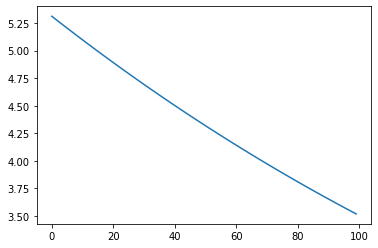

In [ ]:
costs1 = []
costs3 = []
combined_cost = []
for i in range(10000):
    cost1 = leaf1.update(leaf2.vertex)
    cost3 = leaf3.update(leaf2.vertex)
    if i % bs == 0:
        costs1.append(cost1) 
        costs3.append(cost3)
        combined_cost.append(cost1+cost3) 
    
pd.Series(costs1).plot(kind='line')

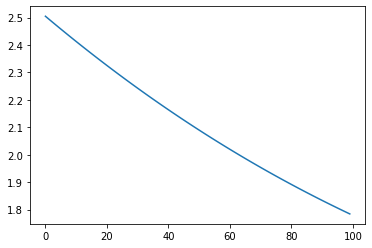

In [ ]:
pd.Series(costs3).plot(kind='line')

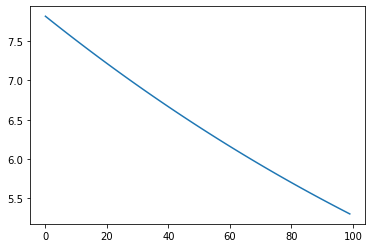

In [ ]:
pd.Series(combined_cost).plot(kind='line')

In [ ]:
emb_length, lr, bs = 10, 1e-4, 100
leaves = [Vertex(emb_length, lr, bs) for i in range(100)]

In [ ]:
leaves = [Leaf(v) for v in leaves]

In [ ]:
tree = Tree.build_tree(leaves, emb_length, lr, bs)

In [ ]:
chosen_leaf = leaves[20]

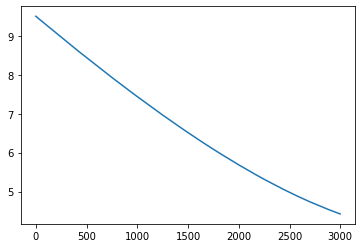

In [ ]:
#slow
costs = []
num_iter = 3000
epoch_costs = [] 
for it in range(num_iter):
    for i in range(100):
        if i == 20:
            continue
        costs.append(leaves[i].update(chosen_leaf.vertex)) 
    epoch_costs.append(np.mean(costs))
    costs = []
s = pd.Series(epoch_costs)
s.plot(kind='line')

This is an interesting result -- it seems a little unusual that we would see training loss going up, but some things to consider:
* In the "real" version, the leaf embeddings are (hopefully) going to have some relationship with the internal node model parameters. In this toy version, we've uniformly initialized all parameters and then trained the model on every single leaf for many iterations. It's basically learning how to optimize random noise.
* We're using plain vanilla batch GD here, with no learning rate annealing (or any of the wide number of GD enhancements that exist). It's very possible that we're getting gradient explosions / divergence towards the end here. 

The goal of hierarchical softmax is to make the scoring function run in $O(logv)$ rather than $O(v)$ by organizing the nodes as a binary tree with a binary classifier at each internal node. At a high level, we follow these steps:
1. We identify a leaf that is contained within the window of our vertex within the current random walk
2. We take that leaf's parent and compute the probability of having followed the correct path (left or right) to the leaf we identified in step 1 by using the model parameters for this internal node combined with the features for the current vertex (which is a row in $\Phi$).
3. We repeat step 2 for all internal nodes until we get to the root
4. The product of all of the internal probabilities gives us the probability of seeing a co-occurrence of the neighbor node given what we know about the node we're exploring
5. $-logPr(u_k|\Phi(v_j))$ is our loss function, where $Pr(u_k|\Phi(v_j))$ is the probability we calculated in step 4
6. We use the loss in step 5 to perform a gradient descent step updating both the parameters of our model and $\Phi(v_j)$:

$$\theta \leftarrow \theta - \alpha_\theta * \frac{\partial J}{\partial \theta}$$
<br>
$$\Phi \leftarrow \Phi - \alpha_\Phi * \frac{\partial J}{\partial \Phi}$$

Where $\theta$ represents all of the parameters of all of the models in the internal nodes of the tree, and $\Phi$ represents the latent representation of the current vertex.